# P2 submission

---

**Requirements**
P2 submission notebook should show :
- That you can handle the data in its size.
- That you understand what’s in the data (formats, distributions, missing values, correlations, etc.).
- That you considered ways to enrich, filter, transform the data according to your needs.
- That you have a reasonable plan and ideas for methods you’re going to use, giving their essential mathematical details in the notebook.
- That your plan for analysis and communication is reasonable and sound, potentially discussing alternatives to your choices that you considered but dropped.



**Project proposal**

Best breweries in the world 

The idea behind the identification of the best breweries is that the consumer might be more interested to try new and/or original products that come from a good brewery. This ranking is based on the ratings given by the tasters, but the ratings have to be weighted by the number of ratings for the best beers, the quality and emotions transmitted in the text following the different ratings. Some ratings might be biased or unclear so some of them might have to be filtered. Once the ranking is determined a visualisation is to be created to convey properly the attributes of the best breweries (number of “quality” beers, rankings by styles).

*Feedback*

Find and visualize the best breweries - clarity: 75 - creativity: 75 - feasibility: 75, using beer-level reviews as a proxy for brewery reviews is doable, yet will require detailed analysis. 

---

# Beer reviews EDA

This dataset consists of beer reviews from two Beer rating websites: BeerAdvocate and RateBeer, for a period of 17 years ranging from 2001 to 2017.

Metadata about users, beers, and breweries (CSV)

In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
import os
import spacy

# Handle size of the data

### Load ratings.txt

In [3]:
def load_txt_file(website):
    if website == 'BeerAdvocate':
        # Specify the directory containing the text files 
        # NB : - need to be outside the repo folder !!
        #      - might need to change the path of the directory below
        directory = './../dataset_BeerReviews/BeerAdvocate/ratings_split_BA/'
    else:
        directory = './../dataset_BeerReviews/RateBeer/ratings_split_RB/'

    # Initialize an empty list to store DataFrames
    dfs = []

    # Loop through the files in reverse order (ratings-5.txt to ratings-1.txt)
    for i in range(1, 0, -1):
        file_name = f'ratings-{i}.txt'
        file_path = os.path.join(directory, file_name)

        with open(file_path, 'r') as f:
            text = f.read()

        # Remove double quotes at the beginning of each line
        data = re.sub('"', '', text)
        data = re.sub(r'^"', '', data, flags=re.MULTILINE)

        # Split the text into individual beer reviews
        beer_reviews = data.split('beer_name')

        # Extract the beer information from each review
        beer_data = []
        for review in beer_reviews:
            beer_info = {}
            for line in [entry.split(':', 1) for entry in review.split('\n') if ':' in entry]:# and 'text' not in entry]:
                if line:  # Check if the list is not empty
                    key, value = line[0].strip(), line[1].strip()
                    beer_info[key] = value
            beer_data.append(beer_info)

        # Convert the beer data into a DataFrame
        df = pd.DataFrame(beer_data)

        # Append the DataFrame to the list
        dfs.append(df)

    # Concatenate all DataFrames into a single DataFrame
    final_df = pd.concat(dfs, ignore_index=True)

    # Rename the columns depending on the website
    if website == 'BeerAdvocate':
        final_df.columns = [
            'beer_name',
            'beer_id',
            'brewery_name',
            'brewery_id',
            'style',
            'abv',
            'date',
            'user_name',
            'user_id',
            'appearance',
            'aroma',
            'palate',
            'taste',
            'overall',
            'rating',
            'text',
            'review'] # additional column compared to RB
    else:
        final_df.columns = [
            'beer_name',
            'beer_id',
            'brewery_name',
            'brewery_id',
            'style',
            'abv',
            'date',
            'user_name',
            'user_id',
            'appearance',
            'aroma',
            'palate',
            'taste',
            'overall',
            'rating',
            'text']
    return final_df

def sample_data(df, ratio):
    # sample the data to make it even smaller
    return df.sample(frac = ratio, random_state=42)

In [88]:
# Load data
ratings_BA = load_txt_file('BeerAdvocate')
ratings_RB = load_txt_file('RateBeer')

In [89]:
# Sample data to make it even smaller AND RANDOMIZED (not randomized in the initial txt splitting process)
ratings_BA = sample_data(df = ratings_BA, ratio = 1)
ratings_RB = sample_data(df = ratings_RB, ratio = 1)

In [90]:
print(len(ratings_BA))
ratings_BA.head(2)

444339


,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review
43736,"Hello, My Name Is Ingrid",67199,BrewDog,16315,American Double / Imperial IPA,8.2,1370426400,aztraz,aztraz.671249,nan,nan,nan,nan,nan,3.50,nan,False
273843,Solstice D'été Aux Cerises,73716,Brasserie Dieu du Ciel!,1141,Berliner Weissbier,6.5,1444644000,hopsolutely,hopsolutely.513175,4.0,4.0,3.5,4.0,3.75,3.90,Enjoying with thanks to Phyl21ca.Rarely does a...,True


In [91]:
print(len(ratings_RB))
ratings_RB.head(2)

446795


,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text
262500,Brew Brothers Prairie Berry Ale,21927,Brew Brothers Brewing &#40;Alberta&#41;,3033,Fruit Beer,5.5,1044615600,presario,5348,3,6,3,7,13,3.20,Big blue 1L bottle. Very loud pop announced t...
39881,Ed Hardy Premium Beer,110849,Cervecería Mexicana (Grupo Modelo),5973,Pale Lager,4.6,1281520800,Cajun,47922,2,4,2,3,5,1.60,Tasting - Gulf Brew 2010 - Pale amber white he...


### Load the other data

In [92]:
# BeerAdvocate
beers_BA = pd.read_csv("./dataset_BeerReviews/BeerAdvocate/beers.csv")
breweries_BA = pd.read_csv("./dataset_BeerReviews/BeerAdvocate/breweries.csv")
users_BA = pd.read_csv("./dataset_BeerReviews/BeerAdvocate/users.csv")

# RateBeer
beers_RB = pd.read_csv("./dataset_BeerReviews/RateBeer/beers.csv")
breweries_RB = pd.read_csv("./dataset_BeerReviews/RateBeer/breweries.csv")
users_RB = pd.read_csv("./dataset_BeerReviews/RateBeer/users.csv")

# matched_beer_data
beers_matched = pd.read_csv("./dataset_BeerReviews/matched_beer_data/beers.csv", header=1)
breweries_matched = pd.read_csv("./dataset_BeerReviews/matched_beer_data/breweries.csv", header = 1)
ratings_matched = pd.read_csv("./dataset_BeerReviews/matched_beer_data/ratings.csv", header=1)
users_approx = pd.read_csv("./dataset_BeerReviews/matched_beer_data/users_approx.csv", header=1)
users_matched = pd.read_csv("./dataset_BeerReviews/matched_beer_data/users.csv", header=1)

## EDA

Do univariate and multivariate analysis


- formats
- distributions
- missing values
- correlations
- etc...

**Organisation of the EDA**
- General data (users, breweries)
- Numerical ratings
- Textual reviews

### General data

In [ ]:
# todo

**Formats**

In [94]:
# Get types of features in each DataFrame
df_types = pd.concat([df.dtypes.rename(f"DataFrame {i+1}") for i, df in enumerate([ratings_BA, ratings_RB])], axis=1)
df_types

,DataFrame 1,DataFrame 2
beer_name,object,object
beer_id,object,object
brewery_name,object,object
brewery_id,object,object
style,object,object
abv,object,object
date,object,object
user_name,object,object
user_id,object,object
appearance,object,object


One can see that all the features of **ratings_BA** and **ratings_RB** have a `object` type, which is not very convenient if we want to automate the visualization process, for example plotting the distribution of the numerical features in histograms. As a first preprocessing step, we will thus convert the type of the numerical variables to `float64` with the function **convert_type** below.

In [95]:
def convert_type(df, col):
    df[col] = df[col].astype('float64')
    return df

# columns including the numerical features for both websites
# user_id is numerical in RB but categorical in BA so we don't include it
numerical_cols = ['beer_id', 'brewery_id', 'abv', 'appearance', 'aroma', 'palate', 'taste', 'overall', 'rating']

for col in numerical_cols : 
    ratings_BA = convert_type(ratings_BA, col)
    ratings_RB = convert_type(ratings_RB, col)

In [97]:
# Get types of features in each DataFrame
df_types = pd.concat([df.dtypes.rename(f"DataFrame {i+1}") for i, df in enumerate([ratings_BA, ratings_RB])], axis=1)
df_types

,DataFrame 1,DataFrame 2
beer_name,object,object
beer_id,float64,float64
brewery_name,object,object
brewery_id,float64,float64
style,object,object
abv,float64,float64
date,object,object
user_name,object,object
user_id,object,object
appearance,float64,float64


### Univariate analysis

**Descriptive statistics**

We can see the missing values per feature in each dataframe.

In [98]:
def get_feature_stats(df):
        """
        Obtains descriptive statistics for all features and percentage of missing values

        Parameters
        ----------
        df : DataFrame containing all data
        
        Returns
        -------
        stats : DataFrame containing the statistics for all features.
        """
        numerical = df.describe(include= ['float64', 'int64'])
        categorical = df.describe(include= ['object'])
        stats = pd.concat([numerical, categorical])
        
        # Select the desired statistics
        stats = stats.loc[['mean', 'std', '50%', 'unique', 'freq']]
        percentage = df.isnull().sum(axis = 0)*100 / len(df)
        stats.loc['missing_values'] = np.array(percentage)
        return stats

In [100]:
display(get_feature_stats(ratings_BA), get_feature_stats(ratings_RB))

,beer_id,brewery_id,abv,appearance,aroma,palate,taste,overall,rating,beer_name,brewery_name,style,date,user_name,user_id,text,review
mean,49930.822187,7393.904217,6.283523,3.763298,3.662354,3.670929,3.713133,3.724937,3.676796,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,64384.554923,10963.761690,2.314747,0.620217,0.684314,0.672210,0.703822,0.681856,0.690097,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,21163.000000,853.000000,5.400000,4.000000,3.750000,3.750000,3.750000,4.000000,3.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22878,1947,104,5809,39863,39863,196394,2
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10046,37472,31061,628,3833,3833,247685,254214
missing_values,0.000225,0.000450,0.000450,0.000450,0.000450,0.783636,0.000450,0.000450,0.000450,36.780926,36.780926,36.780926,36.780926,36.780926,0.00045,0.00045,0.00045


,beer_id,brewery_id,abv,appearance,aroma,palate,taste,overall,rating,beer_name,brewery_name,style,date,user_name,user_id,text
mean,143633.215959,6031.760075,6.134699,3.271936,6.057893,3.071982,6.139671,12.431072,3.097255,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,145026.596254,7227.842634,1.851008,0.835354,1.759857,0.851453,1.730788,3.602640,0.793646,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,95677.000000,2244.000000,5.500000,3.000000,6.000000,3.000000,6.000000,13.000000,3.300000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30957,1940,89,6089,16554,16551,445825
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3650,28394,62348,298,5320,5320,71
missing_values,0.000224,0.000224,0.000224,0.000224,0.000224,2.530243,0.000448,0.000448,0.000448,0.000448,0.000448,0.000448,0.000448,0.000448,0.000448,0.000448


In [68]:
from IPython.display import display, HTML

df1 = get_feature_stats(breweries_BA)
df2 = get_feature_stats(breweries_RB)
df3 = get_feature_stats(users_BA)
df4 = get_feature_stats(users_RB)

# Using HTML/CSS to display DataFrames in the same row
html = f'<div style="display: flex; flex-direction: row;"> \
            <div style="text-align: center; margin-right: 20px;"> \
                <h3>Breweries BeerAdvocate</h3>{df1.to_html()} \
            </div> \
            <div style="text-align: center; margin-right: 100px;"> \
                <h3>Breweries RateBeer</h3>{df2.to_html()} \
            </div> \
            <div style="text-align: center; margin-right: 20px;"> \
                <h3>Users BeerAdovate</h3>{df3.to_html()} \
            </div> \
            <div style="text-align: center;"> \
                <h3>Users RateBeer</h3>{df4.to_html()} \
            </div> \
        </div>'

display(HTML(html))

,id,nbr_beers,location,name
mean,25954.841270,21.056331,NaN,NaN
std,16219.989105,69.417841,NaN,NaN
50%,29178.000000,6.000000,NaN,NaN
unique,NaN,NaN,297,16237
freq,NaN,NaN,1431,34
missing_values,0.000000,0.000000,0.0,0.0
,id,nbr_beers,location,name
mean,16639.680061,19.022655,NaN,NaN
std,9408.751678,31.542620,NaN,NaN
50%,17119.000000,8.000000,NaN,NaN


**Graphical descriptions**

- Users
    - cross data with user_id and user_name de ratings

In [ ]:
# todo

- Breweries

In [127]:
# todo

- Categorical features (except textual reviews)
    - beer_name
    - brewery_name
    - style
    - date
    - review (for BeerAdvocate only)

In [128]:
# todo

**Breweries**

TODO : add explanation why we can only visualize 5% of the breweries

Number of different breweries in BA : 1962
Number of different breweries in RB : 1942


C:\Users\Maxime\AppData\Local\Temp\ipykernel_24804\651483718.py:31: UserWarning: Glyph 146 (\x92) missing from current font.
  plt.tight_layout()
c:\Users\Maxime\anaconda3\envs\ada\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 146 (\x92) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


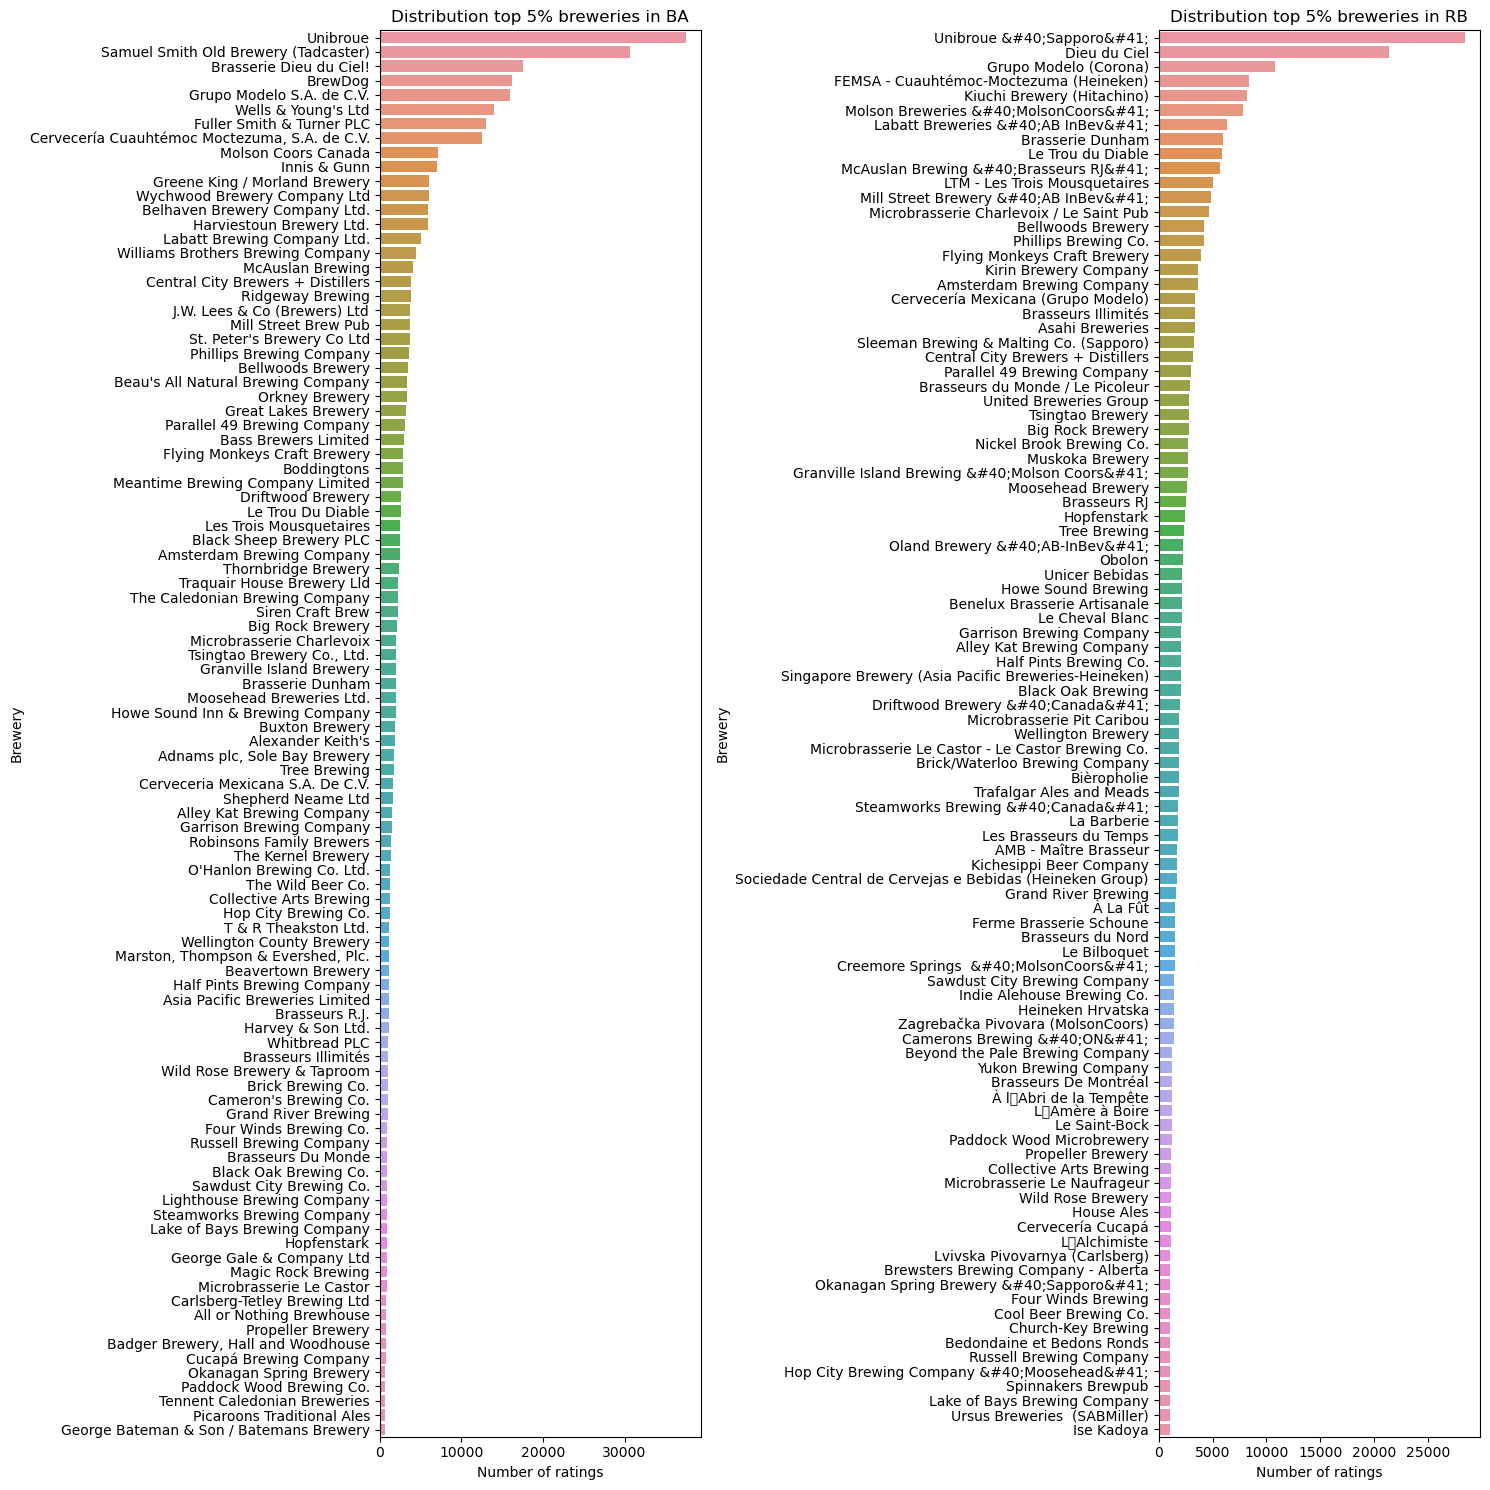

In [132]:
print(f"Number of different breweries in BA : {len(ratings_BA['brewery_id'].unique())}")
print(f"Number of different breweries in RB : {len(ratings_RB['brewery_id'].unique())}")

def filter_topk_breweries(df, k):
    # Find the top k% of breweries most rated
    brewery_count = pd.DataFrame({"count": df.groupby('brewery_name').apply(lambda x: len(x))})
    threshold = brewery_count['count'].quantile(k)
    top_breweries = brewery_count[brewery_count['count'] > threshold].index

    # Filter DataFrame based on the selected brewery names
    df_filtered = df[df['brewery_name'].isin(top_breweries)]
    return df_filtered

ratings_BA_cleaned_copy = ratings_BA.copy()
ratings_RB_cleaned_copy = ratings_RB.copy()

ratings_BA_top5_breweries = filter_topk_breweries(ratings_BA_cleaned_copy, 0.95)
ratings_RB_top5_breweries = filter_topk_breweries(ratings_RB_cleaned_copy, 0.95)

fig, axs = plt.subplots(1,2, figsize=(15, 15))
sns.countplot(y='brewery_name', data = ratings_BA_top5_breweries, order = ratings_BA_top5_breweries['brewery_name'].value_counts().index, ax = axs[0])
sns.countplot(y='brewery_name', data = ratings_RB_top5_breweries, order = ratings_RB_top5_breweries['brewery_name'].value_counts().index, ax = axs[1])

axs[0].set_title("Distribution top 5% breweries in BA")
axs[1].set_title("Distribution top 5% breweries in RB")

for ax in axs.flat:
    ax.set_xlabel("Number of ratings")
    ax.set_ylabel("Brewery")

plt.tight_layout()
plt.show()

**Style**

Number of different style of beers in BA : 105
Number of different style of beers in RB : 90


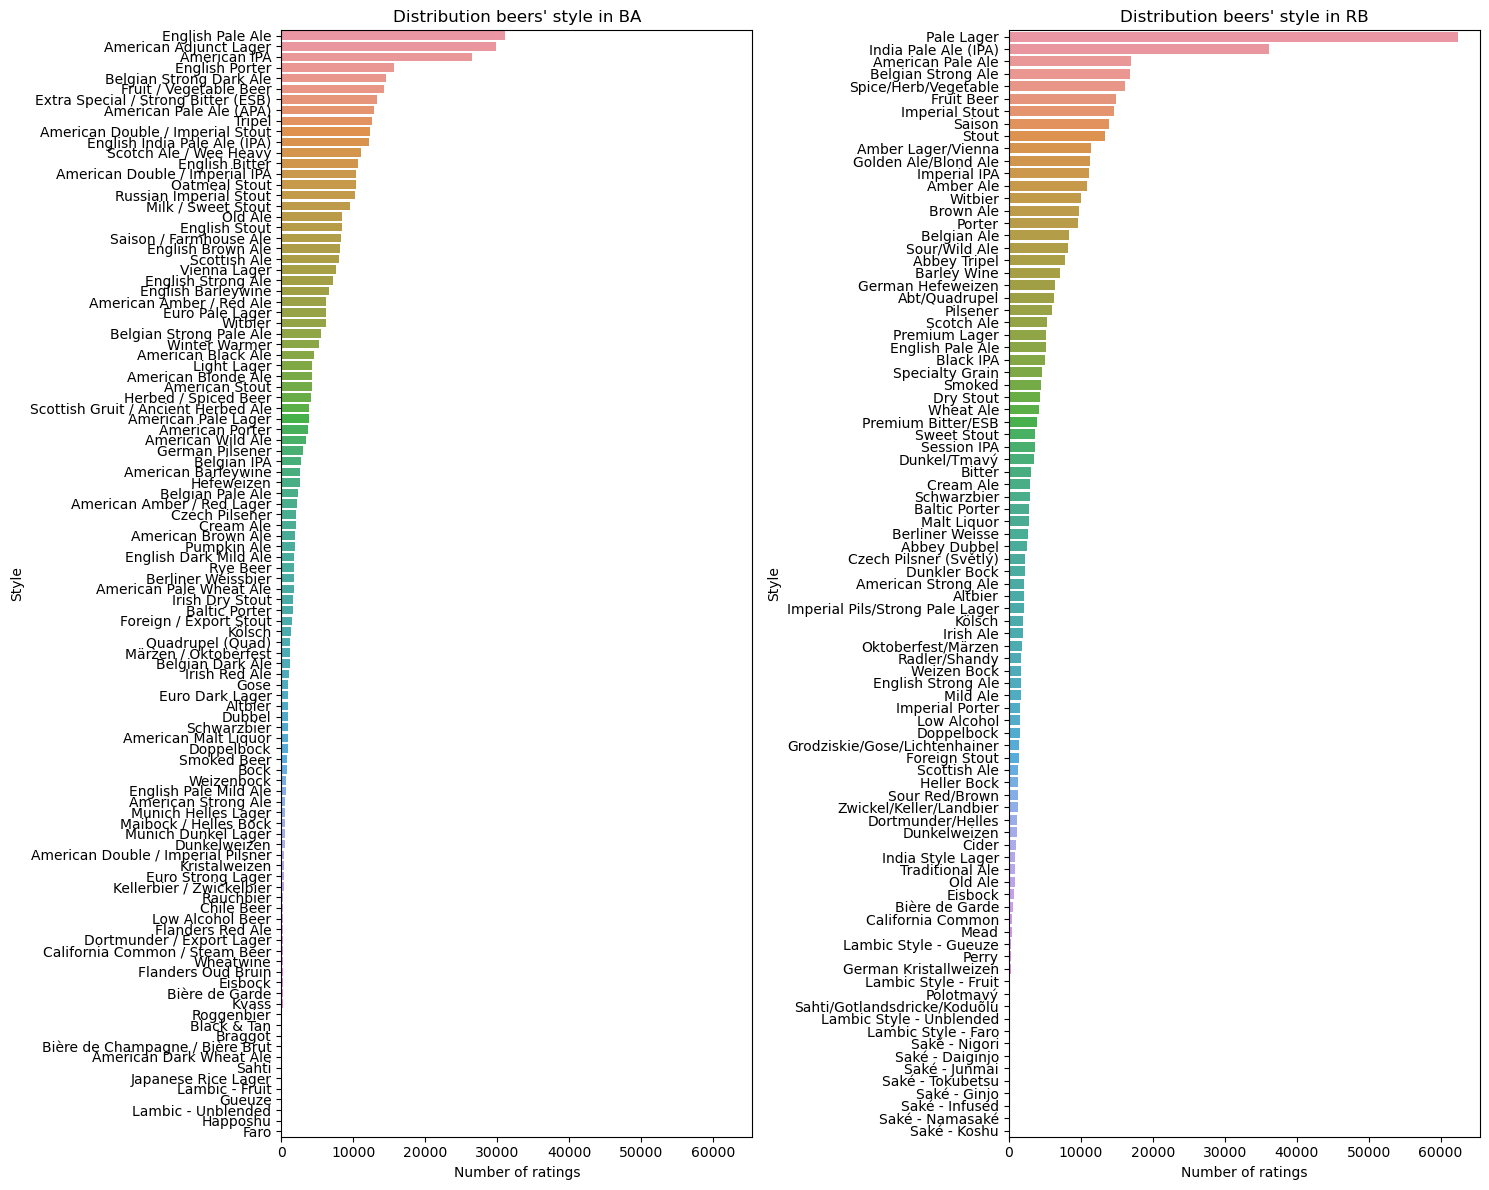

In [130]:
print(f"Number of different style of beers in BA : {len(ratings_BA['style'].unique())}")
print(f"Number of different style of beers in RB : {len(ratings_RB['style'].unique())}")

fig, axs = plt.subplots(1,2, figsize=(15, 12), sharex = True)
sns.countplot(y='style', data=ratings_BA, order = ratings_BA['style'].value_counts().index,ax = axs[0])
sns.countplot(y='style', data=ratings_RB, order = ratings_RB['style'].value_counts().index,ax = axs[1])

axs[0].set_title("Distribution beers' style in BA")
axs[1].set_title("Distribution beers' style in RB")

for ax in axs.flat:
    ax.set_xlabel("Number of ratings")
    ax.set_ylabel("Style")

plt.tight_layout()
plt.show()

- Numerical features
    - abv
    - appearance
    - aroma
    - palate
    - taste
    - overall
    - rating

In [107]:
def plot_features(df, title):
    continuous_cols = ['abv', 'appearance', 'aroma', 'palate', 'taste', 'overall', 'rating'] #list(df._get_numeric_data().columns)
    fig, axes = plt.subplots(2, 4, figsize=(15,10))
    for i, col in enumerate(continuous_cols):
        ax = axes[i // 4, i % 4]
        data = df[~df[col].isna()]
        sns.histplot(data=data[col], bins=50, ax=ax) #Filter out nan values in the features
    fig.suptitle(title)
    fig.tight_layout()
    return fig

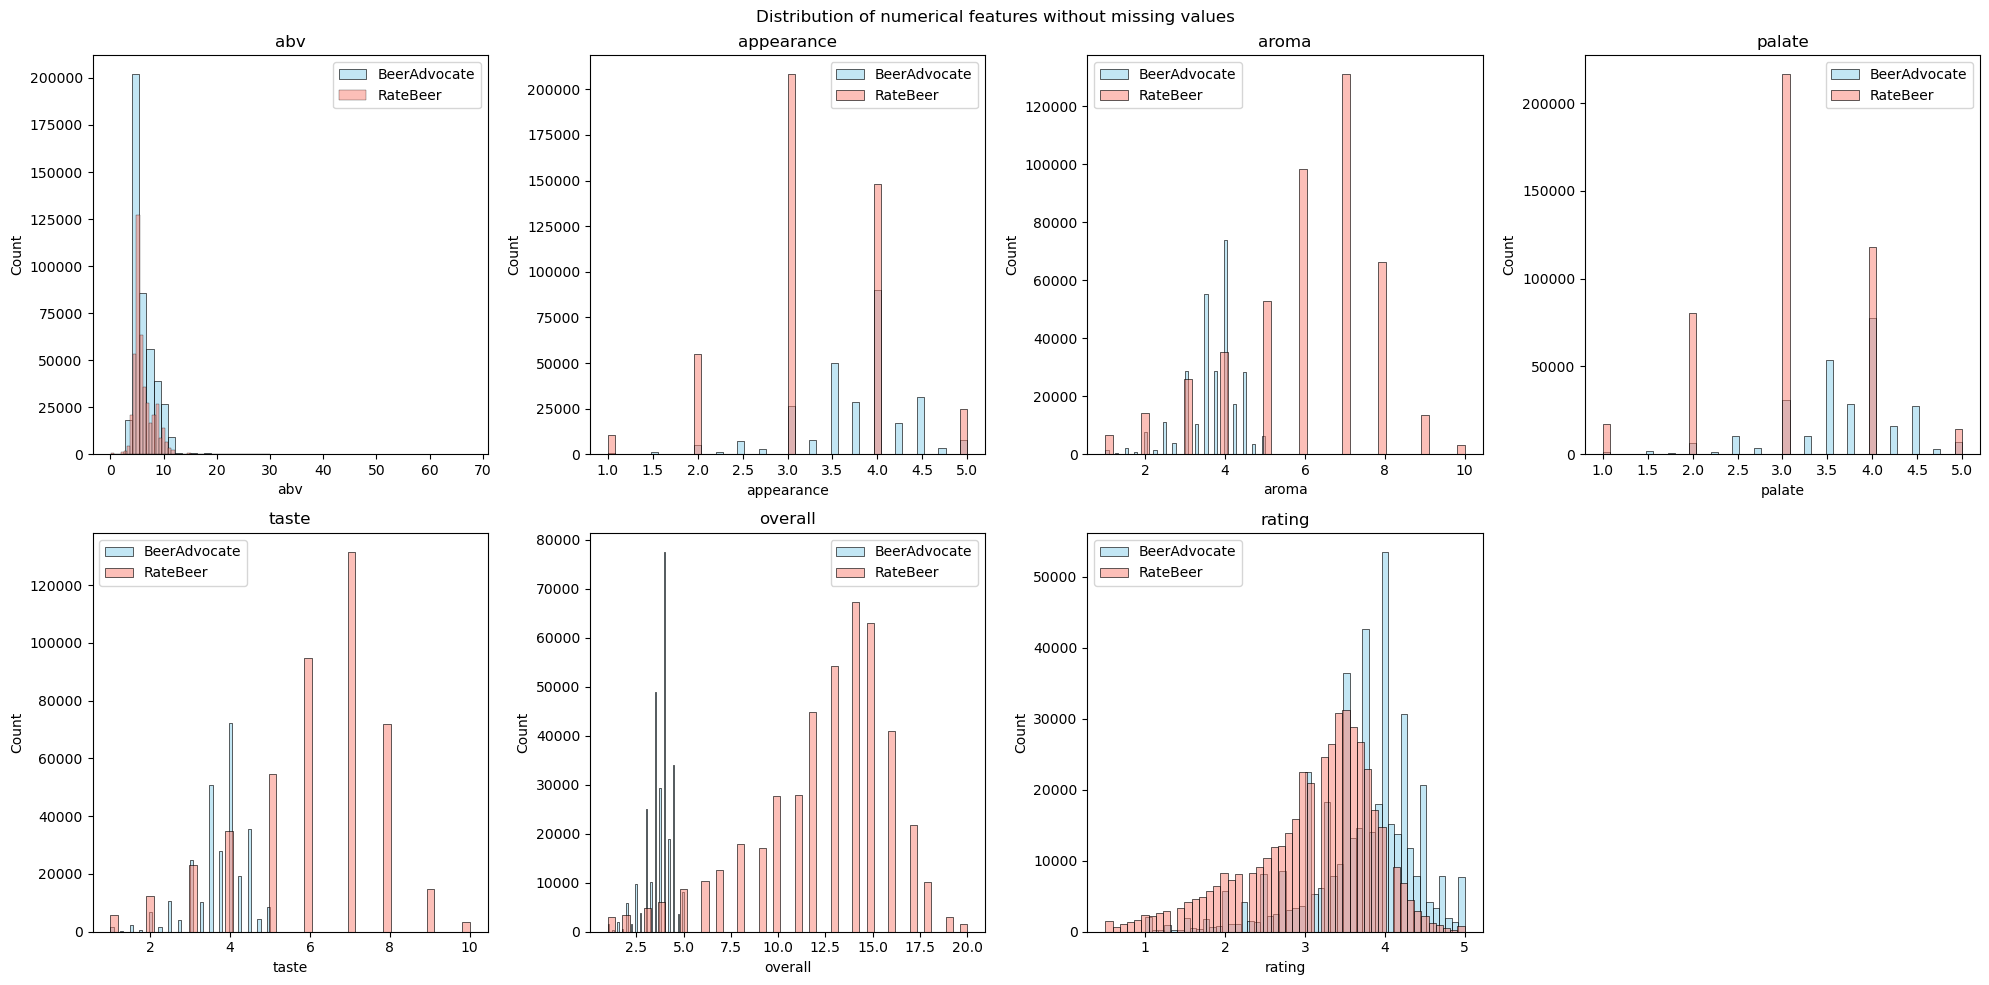

In [115]:
def plot_features(df1, df2, title):
    continuous_cols = ['abv', 'appearance', 'aroma', 'palate', 'taste', 'overall', 'rating']
    fig, axes = plt.subplots(2, 4, figsize=(20,10))
    fig.delaxes(axes[1, 3])
    for i, col in enumerate(continuous_cols):
        ax = axes[i // 4, i % 4]
        sns.histplot(data=df1[~df1[col].isna()], x=col, bins=50, ax=ax, color='skyblue', alpha=0.5, label='BeerAdvocate')
        sns.histplot(data=df2[~df2[col].isna()], x=col, bins=50, ax=ax, color='salmon', alpha=0.5, label='RateBeer')
        ax.set_title(col)
        ax.legend()
    fig.suptitle(title)
    fig.tight_layout()
    return fig

# Assuming ratings_BA and ratings_RB are DataFrames with the same columns
fig = plot_features(ratings_BA, ratings_RB, "Distribution of numerical features without missing values")
plt.show()

 - Textual reviews

    - Number of words
    - sentiment analysis (polarity, subjectivity)

In [116]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download('stopwords') # Download NLTK stopwords
nltk.download('wordnet')   # Lemmatization

# Get the set of English stop words
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Maxime\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Maxime\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [122]:
def preprocess_sentences(df):    
    # Step 1: Remove rows with no sentences (NaN values)
    df = df[~df['text'].isnull()]

    # Step 2: Remove punctuation and convert to lowercase
    def clean_text(sentence):
        translator = str.maketrans('', '', string.punctuation)
        cleaned = sentence.translate(translator).lower()
        return cleaned

    # function to lemmatize 
    def lemmatize_text(sentence):
        tokens = word_tokenize(sentence)
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
        return ' '.join(lemmatized_tokens)

    # Function to remove stop words
    def remove_stopwords(sentence):
        tokens = word_tokenize(sentence)
        filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
        return ' '.join(filtered_tokens)

    df['cleaned_text'] = df['text'].apply(clean_text)
    df['cleaned_text'] = df['cleaned_text'].apply(lemmatize_text)
    df['cleaned_text'] = df['cleaned_text'].apply(remove_stopwords)
    
    return df

def compute_top_words(df):
    # Split the sentences into individual words
    all_words = ' '.join(df['cleaned_text']).split()

    # Count word occurrences
    word_counts = Counter(all_words)

    # Get the top 20 most common words
    top_words = word_counts.most_common(20)

    # Convert to DataFrame for easy plotting
    top_words_df = pd.DataFrame(top_words, columns=['Word', 'Count'])
    
    return top_words_df

In [124]:
import warnings
warnings.filterwarnings('ignore') # remove the warnings

ratings_BA_cleaned = preprocess_sentences(ratings_BA[:100000]) # select some part of the df because sentences cleaning can be long
ratings_RB_cleaned = preprocess_sentences(ratings_RB[:100000])

warnings.filterwarnings('default')

In [125]:
ratings_BA_cleaned.head(2)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review,cleaned_text
43736,"Hello, My Name Is Ingrid",67199.0,BrewDog,16315.0,American Double / Imperial IPA,8.2,1370426400,aztraz,aztraz.671249,NaN,NaN,NaN,NaN,NaN,3.5,nan,False,nan
273843,Solstice D'été Aux Cerises,73716.0,Brasserie Dieu du Ciel!,1141.0,Berliner Weissbier,6.5,1444644000,hopsolutely,hopsolutely.513175,4.0,4.0,3.5,4.0,3.75,3.9,Enjoying with thanks to Phyl21ca.Rarely does a...,True,enjoying thanks phyl21cararely doe bottle embo...


Average number of words in textual reviews of BA : 290.318211995796
Average number of words in textual reviews of RB : 308.98221555747045

Number of sentences with NaN/0 words in BA :2
Number of sentences with NaN/0 words in RB :2
Average number of words in textual reviews of BA : 201.51260512605126
Average number of words in textual reviews of RB : 237.9030490304903

Number of sentences with NaN/0 words in BA :0
Number of sentences with NaN/0 words in RB :0


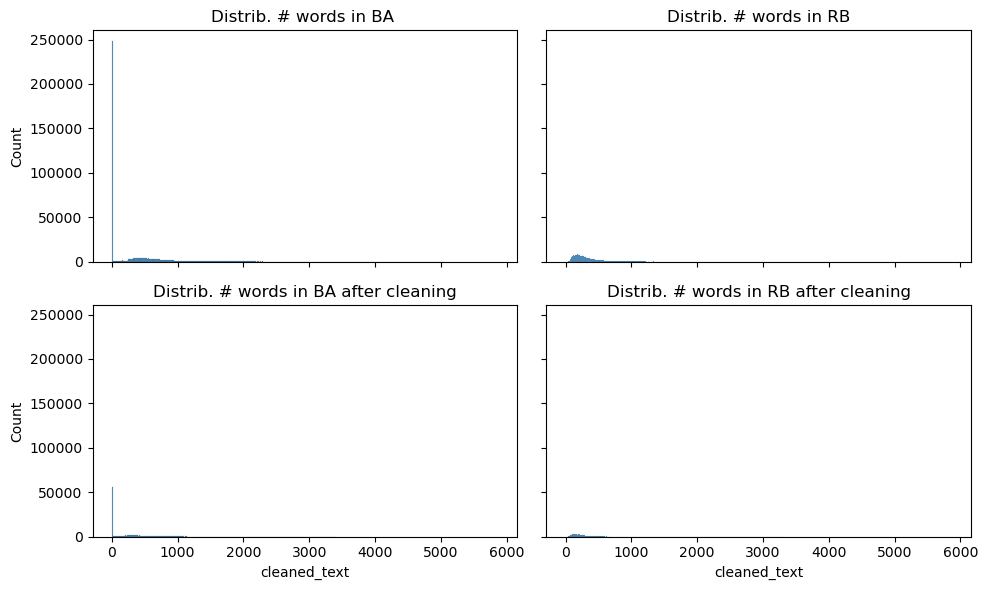

In [126]:
# Before preprocessing of the sentences
mean_words_BA = np.mean(ratings_BA["text"].apply(lambda row : len(str(row))))
mean_words_RB = np.mean(ratings_RB["text"].apply(lambda row : len(str(row))))
print(f"Average number of words in textual reviews of BA : {mean_words_BA}")
print(f"Average number of words in textual reviews of RB : {mean_words_RB}")

NaN_sentences_BA = len(ratings_BA[ratings_BA["text"].isnull()])
NaN_sentences_RB = len(ratings_RB[ratings_RB["text"].isnull()])
print(f"\nNumber of sentences with NaN/0 words in BA :{NaN_sentences_BA}")
print(f"Number of sentences with NaN/0 words in RB :{NaN_sentences_RB}")

# After preprocessing of the sentences
mean_words_BA = np.mean(ratings_BA_cleaned["cleaned_text"].apply(lambda row : len(str(row))))
mean_words_RB = np.mean(ratings_RB_cleaned["cleaned_text"].apply(lambda row : len(str(row))))
print(f"Average number of words in textual reviews of BA : {mean_words_BA}")
print(f"Average number of words in textual reviews of RB : {mean_words_RB}")

NaN_sentences_BA = len(ratings_BA_cleaned[ratings_BA_cleaned["cleaned_text"].isnull()])
NaN_sentences_RB = len(ratings_RB_cleaned[ratings_RB_cleaned["cleaned_text"].isnull()])
print(f"\nNumber of sentences with NaN/0 words in BA :{NaN_sentences_BA}")
print(f"Number of sentences with NaN/0 words in RB :{NaN_sentences_RB}")

fig, axs = plt.subplots(2,2, figsize=(10,6), sharex = True, sharey = True)
sns.histplot(data = ratings_BA['text'].apply(lambda row : len(str(row))), ax = axs[0,0])
sns.histplot(data = ratings_RB['text'].apply(lambda row : len(str(row))), ax = axs[0,1])
sns.histplot(data = ratings_BA_cleaned['cleaned_text'].apply(lambda row : len(str(row))), ax = axs[1,0])
sns.histplot(data = ratings_RB_cleaned['cleaned_text'].apply(lambda row : len(str(row))), ax = axs[1,1])

axs[0,0].set_title("Distrib. # words in BA ")
axs[0,1].set_title("Distrib. # words in RB")
axs[1,0].set_title("Distrib. # words in BA after cleaning")
axs[1,1].set_title("Distrib. # words in RB after cleaning")
plt.tight_layout()
plt.show()

### Multivariate analysis

**Descriptive statistics**

In [134]:
# compute correlation

## Data preprocessing

- enrichment
- filtering
- transformation

### Filtering

In [ ]:
# todo

### Transformation

- **date** feature

In [133]:
#Convert date 

pd.to_numeric(ratings_BA['date'], errors='coerce', downcast='integer')#.astype(int)
ratings_BA_d = ratings_BA.copy()
ratings_BA_d.date = ratings_BA.date.apply(lambda d: pd.to_datetime(d, unit='s'))
ratings_BA_d['date'] = ratings_BA_d['date'].dt.date
ratings_BA_d.head()

C:\Users\Maxime\AppData\Local\Temp\ipykernel_24804\2187802326.py:5: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  ratings_BA_d.date = ratings_BA.date.apply(lambda d: pd.to_datetime(d, unit='s'))


,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review
43736,"Hello, My Name Is Ingrid",67199.0,BrewDog,16315.0,American Double / Imperial IPA,8.2,2013-06-05,aztraz,aztraz.671249,NaN,NaN,NaN,NaN,NaN,3.50,nan,False
273843,Solstice D'été Aux Cerises,73716.0,Brasserie Dieu du Ciel!,1141.0,Berliner Weissbier,6.5,2015-10-12,hopsolutely,hopsolutely.513175,4.0,4.0,3.5,4.0,3.75,3.90,Enjoying with thanks to Phyl21ca.Rarely does a...,True
169417,O'Hanlons Organic Rye,9123.0,O'Hanlon Brewing Co. Ltd.,1533.0,Rye Beer,5.0,2008-06-29,aerozeppl,aerozeppl.101084,3.0,3.0,4.0,3.0,3.00,3.10,A: 2 Finger pour. White head with some piting....,True
25783,Fraoch Heather Ale,245.0,Williams Brothers Brewing Company,12142.0,Scottish Gruit / Ancient Herbed Ale,5.0,2013-08-07,ekalb31,ekalb31.747152,NaN,NaN,NaN,NaN,NaN,3.50,nan,False
90288,Samuel Smith's Pure Brewed Organic Lager Beer,778.0,Samuel Smith Old Brewery (Tadcaster),113.0,Euro Pale Lager,5.0,2006-10-11,jasonjlewis,jasonjlewis.74038,4.0,4.5,4.0,4.0,4.00,4.12,This beer is really a no frills beer to relax ...,True


- **text** feature

In [135]:
# todo

## Feasibility check of project's methods
- give their essential mathematical details in the notebook.

In [ ]:
# todo

## Alternatives considered
- analysis and communication is reasonable

In [ ]:
# todo